# Bayesian Regression of Sea Ice Area

### Data Source:
[The National Snow and Ice Data Center (NSIDC) Sea Ice Index](https://nsidc.org/data/G02135/versions/3).

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import pymuqModeling as mm
import pymuqApproximationWrappers as ma

## Read the September data

In [3]:
sep_df = pd.read_csv('data/N_09_extent_v3.0.csv',  sep="\s*,\s*", engine='python')

In [4]:
sep_df.head()

,year,mo,data-type,region,extent,area
0,1979,9,Goddard,N,7.05,4.58
1,1980,9,Goddard,N,7.67,4.87
2,1981,9,Goddard,N,7.14,4.44
3,1982,9,Goddard,N,7.30,4.43
4,1983,9,Goddard,N,7.39,4.70


In [5]:
print('Average September Area = %0.2f [million km^2]'%sep_df['area'].mean())

Average September Area = 4.19 [million km^2]


## Read the March data

In [6]:
mar_df = pd.read_csv('data/N_03_extent_v3.0.csv', sep="\s*,\s*", engine='python')

In [7]:
mar_df.head()

,year,mo,data-type,region,extent,area
0,1979,3,Goddard,N,16.34,13.21
1,1980,3,Goddard,N,16.04,12.99
2,1981,3,Goddard,N,15.63,12.71
3,1982,3,Goddard,N,16.04,13.07
4,1983,3,Goddard,N,16.09,12.93


In [8]:
print('Average March Area = %0.2f [million km^2]'%mar_df['area'].mean())

Average March Area = 13.13 [million km^2]


## Compare the winter and summer

In [9]:
# Compute the average from 1980-2000
sep_avg = sep_df[sep_df['year']<=2000]['area'].mean()
mar_avg = mar_df[mar_df['year']<=2000]['area'].mean()

sep_df['area_anomaly'] = sep_df['area']-sep_avg
mar_df['area_anomaly'] = mar_df['area']-mar_avg

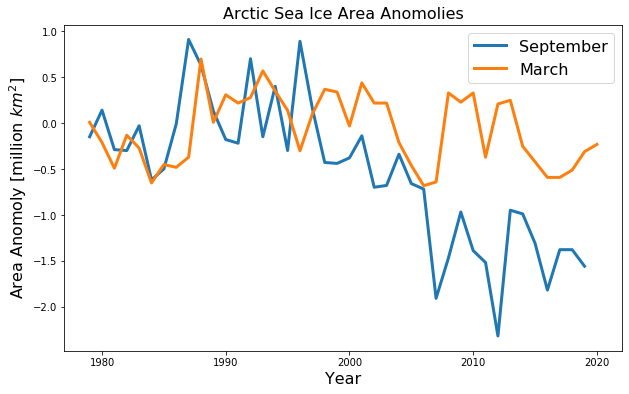

In [10]:
# Plot the anomolies (value-avg)

plt.subplots(figsize=(10,6))

plt.plot(sep_df['year'],sep_df['area_anomaly'], linewidth=3, label='September')
plt.plot(mar_df['year'],mar_df['area_anomaly'], linewidth=3, label='March')

plt.ylabel('Area Anomoly [million $km^2$]', fontsize=16)
plt.xlabel('Year', fontsize=16)
plt.title('Arctic Sea Ice Area Anomolies', fontsize=16)

plt.legend(fontsize=16)
plt.show()

## Perform the September regression

In [11]:
def CreateVandermonde(order, years):
    """  Constructs a Vandermonde matrix with monomials up to 
         the polynomial order (i.e. power) specified in the 
         input arguments.
    """
    V = np.ones((years.shape[0], order+1))
    for i in range(1,order+1):
        V[:,i] = years**i
        
    return V

def ConstructPrior(order):
    prior_mean = np.zeros((order+1))
    prior_std =  1*np.ones((order+1))
    
    prior_var = prior_std*prior_std
    return mm.Gaussian(prior_mean, prior_var)
    
def ConstructPosterior(prior, obs_df, obs_var):
    
    obs_var_vec = obs_var*np.ones(obs_df.shape[0])
    
    order = prior.Dimension()-1
    
    start_year = 1979
    years = np.array(obs_df['year']-start_year, dtype=np.float64)
    
    obs = np.array(obs_df['area_anomaly'], dtype=np.float64)

    V = CreateVandermonde(order, years)

    
    return prior.Condition(V,  obs, obs_var_vec)

In [12]:
order = 1
obs_var = 0.5**2

sep_prior = ConstructPrior(order)
sep_post = ConstructPosterior(sep_prior, sep_df, obs_var)

In [13]:
start_year = 1979
pred_years = np.arange(start_year,2051)-start_year
V_pred = CreateVandermonde(order, pred_years)

In [14]:
prior_pred_mean = V_pred@sep_prior.GetMean()
prior_pred_cov = V_pred@sep_prior.ApplyCovariance(V_pred.T) + obs_var*np.eye(pred_years.shape[0])
prior_pred_std = np.sqrt(np.diag(prior_pred_cov))

#### Compute the posterior predictive mean and covariance

In [15]:
pred_mean = V_pred@sep_post.GetMean()
pred_cov = V_pred@sep_post.ApplyCovariance(V_pred.T) + obs_var*np.eye(pred_years.shape[0])
pred_std = np.sqrt(np.diag(pred_cov))

#### Plot the posterior predictive

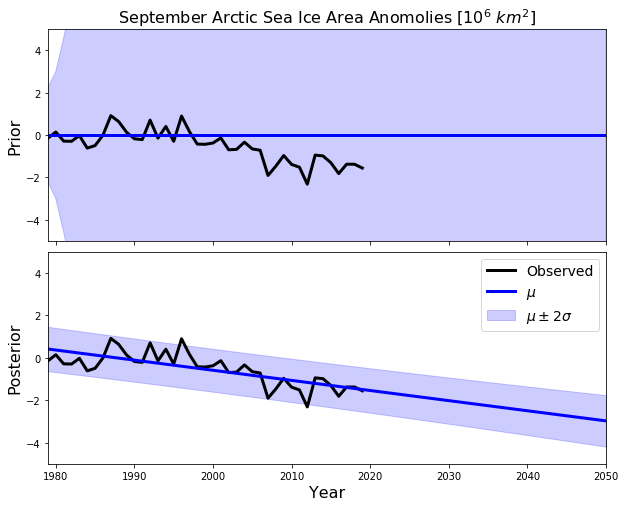

In [16]:
fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(10,8))

axs[1].plot(sep_df['year'],sep_df['area_anomaly'], 'k', linewidth=3, label='Observed')
axs[0].plot(sep_df['year'],sep_df['area_anomaly'], 'k', linewidth=3, label='Observed')

axs[0].fill_between(pred_years+start_year, prior_pred_mean-2.0*prior_pred_std, prior_pred_mean+2.0*prior_pred_std, color='b', alpha=0.2, label='$\mu\pm2\sigma$')
axs[0].plot(pred_years+start_year,prior_pred_mean, 'b', linewidth=3, label='Posterior $\mu$')
axs[0].set_ylim([-5,5])

axs[1].fill_between(pred_years+start_year, pred_mean-2.0*pred_std, pred_mean+2.0*pred_std, color='b', alpha=0.2, label='$\mu\pm2\sigma$')
axs[1].plot(pred_years+start_year,pred_mean, 'b', linewidth=3, label='$\mu$')
axs[1].set_ylim([-5,5])

axs[1].set_xlim([pred_years[0]+start_year,pred_years[-1]+start_year])
axs[1].set_ylabel('Posterior', fontsize=16)
axs[0].set_ylabel('Prior', fontsize=16)
axs[1].set_xlabel('Year', fontsize=16)
axs[0].set_title('September Arctic Sea Ice Area Anomolies [$10^6$ $km^2$]', fontsize=16)

axs[1].legend(fontsize=14)
plt.subplots_adjust(wspace=0.01, hspace=0.05)
plt.show()

#### Compute posterior model probabilities and Bayes factors

In [17]:
def ComputeEvidence(dist, obs_df):
    order = dist.Dimension()-1
    
    years  = obs_df['year']
    years -= years[0]
    
    V =  CreateVandermonde(order, years)
    
    pred_mean = V@dist.GetMean()
    pred_cov = V@dist.ApplyCovariance(V.T) + obs_var*np.eye(obs_df.shape[0])

    pred_dist = mm.Gaussian(pred_mean,pred_cov)
    log_evidence = pred_dist.LogDensity(obs_df['area'].to_numpy())
    
    return log_evidence

In [18]:
all_orders = [0,1,2,3,4]
log_evidences = np.zeros(len(all_orders))

for i in range(len(all_orders)):
    prior = ConstructPrior(all_orders[i])
    log_evidences[i] = ComputeEvidence(prior, sep_df)
    
evidences = np.exp(log_evidences)
model_probs = evidences/np.sum(evidences) # <- Bayes' rule over models with uniform prior

print('Posterior Model Probabilities:')
for i in range(len(all_orders)):
    print('Order %d, Prob %0.2f'%(all_orders[i], model_probs[i]))
    
print('')
print('Bayes Factor Order 1 / Order 2:') 
print(np.exp(log_evidences[1]-log_evidences[2]))

Posterior Model Probabilities:
Order 0, Prob 0.00
Order 1, Prob 0.72
Order 2, Prob 0.28
Order 3, Prob 0.00
Order 4, Prob 0.00

Bayes Factor Order 1 / Order 2:
2.5483356298459823


## Perform the March regression

In [19]:
mar_prior = ConstructPrior(order)
mar_post = ConstructPosterior(mar_prior, mar_df, obs_var)

In [20]:
prior_pred_mean = V_pred@mar_prior.GetMean()
prior_pred_cov = V_pred@mar_prior.ApplyCovariance(V_pred.T) + obs_var*np.eye(pred_years.shape[0])
prior_pred_std = np.sqrt(np.diag(prior_pred_cov))

In [21]:
pred_mean = V_pred@mar_post.GetMean()
pred_cov = V_pred@mar_post.ApplyCovariance(V_pred.T) + obs_var*np.eye(pred_years.shape[0])
pred_std = np.sqrt(np.diag(pred_cov))

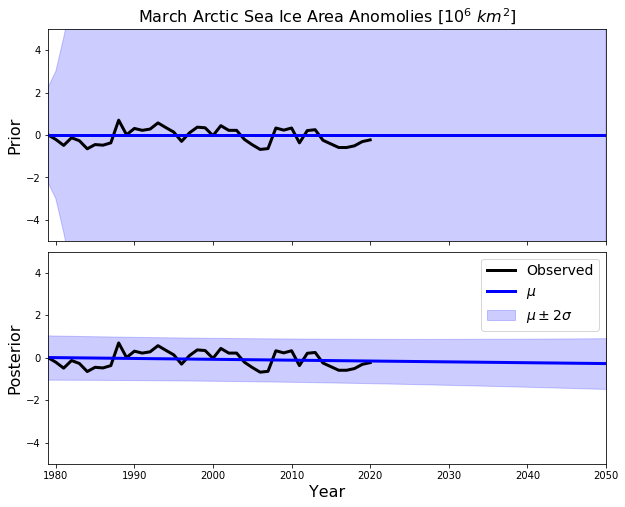

In [22]:
fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(10,8))

axs[1].plot(mar_df['year'],mar_df['area_anomaly'], 'k', linewidth=3, label='Observed')
axs[0].plot(mar_df['year'],mar_df['area_anomaly'], 'k', linewidth=3, label='Observed')

axs[0].fill_between(pred_years+start_year, prior_pred_mean-2.0*prior_pred_std, prior_pred_mean+2.0*prior_pred_std, color='b', alpha=0.2, label='$\mu\pm2\sigma$')
axs[0].plot(pred_years+start_year,prior_pred_mean, 'b', linewidth=3, label='Posterior $\mu$')
axs[0].set_ylim([-5,5])

axs[1].fill_between(pred_years+start_year, pred_mean-2.0*pred_std, pred_mean+2.0*pred_std, color='b', alpha=0.2, label='$\mu\pm2\sigma$')
axs[1].plot(pred_years+start_year,pred_mean, 'b', linewidth=3, label='$\mu$')
axs[1].set_ylim([-5,5])

axs[1].set_xlim([pred_years[0]+start_year,pred_years[-1]+start_year])
axs[1].set_ylabel('Posterior', fontsize=16)
axs[0].set_ylabel('Prior', fontsize=16)
axs[1].set_xlabel('Year', fontsize=16)
axs[0].set_title('March Arctic Sea Ice Area Anomolies [$10^6$ $km^2$]', fontsize=16)

axs[1].legend(fontsize=14)
plt.subplots_adjust(wspace=0.01, hspace=0.05)
plt.show()

#### Compute model probabilities and Bayes factors for March

In [23]:
all_orders = [0,1,2,3,4]
log_evidences = np.zeros(len(all_orders))

for i in range(len(all_orders)):
    prior = ConstructPrior(all_orders[i])
    log_evidences[i] = ComputeEvidence(prior, mar_df)
    
evidences = np.exp(log_evidences)
model_probs = evidences/np.sum(evidences) # <- Bayes' rule over models with uniform prior

print('Posterior Model Probabilities:')
for i in range(len(all_orders)):
    print('Order %d, Prob %0.2f'%(all_orders[i], model_probs[i]))
    
print('')
print('Bayes Factor Order 0 / Order 1:') 
print(np.exp(log_evidences[0]-log_evidences[1]))

Posterior Model Probabilities:
Order 0, Prob 0.93
Order 1, Prob 0.01
Order 2, Prob 0.06
Order 3, Prob 0.00
Order 4, Prob 0.00

Bayes Factor Order 0 / Order 1:
90.05706350200252
